## Get data about Paris neighborhoods

Le quartier désigne la division administrative de l’arrondissement. Chaque arrondissement est découpé
en quatre quartiers administratifs. Paris compte ainsi quatre-vingt quartiers administratifs.

### Import libraries

In [1]:
import pandas as pd
print('Pandas library imported.')
import requests
print('Requests library imported.')
from bs4 import BeautifulSoup
print('BeautifulSoup library imported.')

print('All libraries imported.')

Pandas library imported.
Requests library imported.
BeautifulSoup library imported.
All libraries imported.


### Get the data about neighborhoods of Paris

Get a csv from the site of the City of Paris: https://opendata.paris.fr/explore/dataset/quartier_paris/export/

In [2]:
!wget --quiet https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv -O paris_neighborhoods.csv

print('CSV file downloaded!')

CSV file downloaded!


In [3]:
paris_neighborhoods = pd.read_csv('paris_neighborhoods.csv', sep=';')

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))

print('The five first rows are:')
paris_neighborhoods.head()

The dataframe shape is (80, 10).
The five first rows are:


,n_sq_qu,c_qu,c_quinsee,l_qu,c_ar,n_sq_ar,perimetre,surface,geom_x_y,geom
0,750000021,21,7510601,Monnaie,6,750000006,2391.122818,2.933606e+05,"48.8543844036,2.34003537113","{""type"": ""Polygon"", ""coordinates"": [[[2.343168..."
1,750000022,22,7510602,Odéon,6,750000006,3516.314464,7.161484e+05,"48.8478006293,2.33633882759","{""type"": ""Polygon"", ""coordinates"": [[[2.336988..."
2,750000029,29,7510801,Champs-Elysées,8,750000008,5480.652870,1.140254e+06,"48.8670744922,2.30865168468","{""type"": ""Polygon"", ""coordinates"": [[[2.306463..."
3,750000051,51,7511303,Maison-Blanche,13,750000013,6814.373288,2.231506e+06,"48.8231278057,2.35243314954","{""type"": ""Polygon"", ""coordinates"": [[[2.349115..."
4,750000052,52,7511304,Croulebarbe,13,750000013,3289.230480,6.920677e+05,"48.8337336761,2.34767304607","{""type"": ""Polygon"", ""coordinates"": [[[2.351662..."


### Cleaning the dataframe

Drop the columns we will not use

In [4]:
paris_neighborhoods.drop(['n_sq_qu', 'geom', 'n_sq_ar'], axis='columns', inplace=True)

paris_neighborhoods.head()

,c_qu,c_quinsee,l_qu,c_ar,perimetre,surface,geom_x_y
0,21,7510601,Monnaie,6,2391.122818,2.933606e+05,"48.8543844036,2.34003537113"
1,22,7510602,Odéon,6,3516.314464,7.161484e+05,"48.8478006293,2.33633882759"
2,29,7510801,Champs-Elysées,8,5480.652870,1.140254e+06,"48.8670744922,2.30865168468"
3,51,7511303,Maison-Blanche,13,6814.373288,2.231506e+06,"48.8231278057,2.35243314954"
4,52,7511304,Croulebarbe,13,3289.230480,6.920677e+05,"48.8337336761,2.34767304607"


Rename the columns

In [5]:
paris_neighborhoods.columns = ['NeighborhoodNumber', 'NeighborhoodCode', 'Neighborhood', 'DistrictNumber', 'Perimeter', 'Area', 'Coordinates']

paris_neighborhoods.head()

,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Coordinates
0,21,7510601,Monnaie,6,2391.122818,2.933606e+05,"48.8543844036,2.34003537113"
1,22,7510602,Odéon,6,3516.314464,7.161484e+05,"48.8478006293,2.33633882759"
2,29,7510801,Champs-Elysées,8,5480.652870,1.140254e+06,"48.8670744922,2.30865168468"
3,51,7511303,Maison-Blanche,13,6814.373288,2.231506e+06,"48.8231278057,2.35243314954"
4,52,7511304,Croulebarbe,13,3289.230480,6.920677e+05,"48.8337336761,2.34767304607"


Split the coordinates in 2 columns

In [6]:
paris_neighborhoods[['Latitude', 'Longitude']] = paris_neighborhoods.Coordinates.str.split(",", expand=True)
paris_neighborhoods.drop(['Coordinates'], axis='columns', inplace=True)

paris_neighborhoods.head()

,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Latitude,Longitude
0,21,7510601,Monnaie,6,2391.122818,2.933606e+05,48.8543844036,2.34003537113
1,22,7510602,Odéon,6,3516.314464,7.161484e+05,48.8478006293,2.33633882759
2,29,7510801,Champs-Elysées,8,5480.652870,1.140254e+06,48.8670744922,2.30865168468
3,51,7511303,Maison-Blanche,13,6814.373288,2.231506e+06,48.8231278057,2.35243314954
4,52,7511304,Croulebarbe,13,3289.230480,6.920677e+05,48.8337336761,2.34767304607


Get more information from Wikipedia
Scrape the wikipedia page about the neighborhoods of Paris: https://en.wikipedia.org/wiki/Quarters_of_Paris

In [7]:
result = requests.get("https://en.wikipedia.org/wiki/Quarters_of_Paris")
soup = BeautifulSoup(result.content,'lxml')
table = soup.find_all('table')[0] 
paris_neighborhoods_wikipedia = pd.read_html(str(table))[0]

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))

print('The five first rows are:')
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 6).
The five first rows are:


,Arrondissement(Districts),Quartiers(Quarters),Quartiers(Quarters).1,Population in1999[3],Area(hectares)[3],Map
0,"1st arrondissement(Called ""du Louvre"")",1st,Saint-Germain-l'Auxerrois,1672,86.9,NaN
1,"1st arrondissement(Called ""du Louvre"")",2nd,Les Halles,8984,41.2,NaN
2,"1st arrondissement(Called ""du Louvre"")",3rd,Palais-Royal,3195,27.4,NaN
3,"1st arrondissement(Called ""du Louvre"")",4th,Place-Vendôme,3044,26.9,NaN
4,"2nd arrondissement(Called ""de la Bourse"")",5th,Gaillon,1345,18.8,NaN


Drop the columns we will not use

In [8]:
paris_neighborhoods_wikipedia.drop(['Quartiers(Quarters).1', 'Area(hectares)[3]', 'Map'], axis='columns', inplace=True)

paris_neighborhoods_wikipedia.head()

,Arrondissement(Districts),Quartiers(Quarters),Population in1999[3]
0,"1st arrondissement(Called ""du Louvre"")",1st,1672
1,"1st arrondissement(Called ""du Louvre"")",2nd,8984
2,"1st arrondissement(Called ""du Louvre"")",3rd,3195
3,"1st arrondissement(Called ""du Louvre"")",4th,3044
4,"2nd arrondissement(Called ""de la Bourse"")",5th,1345


Rename the columns

In [9]:
paris_neighborhoods_wikipedia.columns = ['District', 'NeighborhoodNumber', 'Population']

paris_neighborhoods_wikipedia.head()

,District,NeighborhoodNumber,Population
0,"1st arrondissement(Called ""du Louvre"")",1st,1672
1,"1st arrondissement(Called ""du Louvre"")",2nd,8984
2,"1st arrondissement(Called ""du Louvre"")",3rd,3195
3,"1st arrondissement(Called ""du Louvre"")",4th,3044
4,"2nd arrondissement(Called ""de la Bourse"")",5th,1345


Split the district official name (number of the "arrondissement") and the "also called" named (which is not commonly used in Paris)

In [10]:
paris_neighborhoods_wikipedia[['District', 'DistrictName']] = paris_neighborhoods_wikipedia.District.str.split("(",expand=True,)

paris_neighborhoods_wikipedia.head()

,District,NeighborhoodNumber,Population,DistrictName
0,1st arrondissement,1st,1672,"Called ""du Louvre"")"
1,1st arrondissement,2nd,8984,"Called ""du Louvre"")"
2,1st arrondissement,3rd,3195,"Called ""du Louvre"")"
3,1st arrondissement,4th,3044,"Called ""du Louvre"")"
4,2nd arrondissement,5th,1345,"Called ""de la Bourse"")"


Make the district name more beautiful

In [11]:
paris_neighborhoods_wikipedia[['DistrictName']] = paris_neighborhoods_wikipedia.DistrictName.str.replace('Called \"', 'Arrondissement ')
paris_neighborhoods_wikipedia[['DistrictName']] = paris_neighborhoods_wikipedia.DistrictName.str.replace("\"\)", '')

paris_neighborhoods_wikipedia.head()

,District,NeighborhoodNumber,Population,DistrictName
0,1st arrondissement,1st,1672,Arrondissement du Louvre
1,1st arrondissement,2nd,8984,Arrondissement du Louvre
2,1st arrondissement,3rd,3195,Arrondissement du Louvre
3,1st arrondissement,4th,3044,Arrondissement du Louvre
4,2nd arrondissement,5th,1345,Arrondissement de la Bourse


Remove letters from the neighborhood code

In [12]:
paris_neighborhoods_wikipedia[['NeighborhoodNumber']] = paris_neighborhoods_wikipedia.NeighborhoodNumber.str[:-2]
paris_neighborhoods_wikipedia = paris_neighborhoods_wikipedia.astype({'NeighborhoodNumber': int})

paris_neighborhoods_wikipedia.head()

,District,NeighborhoodNumber,Population,DistrictName
0,1st arrondissement,1,1672,Arrondissement du Louvre
1,1st arrondissement,2,8984,Arrondissement du Louvre
2,1st arrondissement,3,3195,Arrondissement du Louvre
3,1st arrondissement,4,3044,Arrondissement du Louvre
4,2nd arrondissement,5,1345,Arrondissement de la Bourse


In [13]:
paris_neighborhoods = pd.merge(paris_neighborhoods, paris_neighborhoods_wikipedia, on='NeighborhoodNumber')

paris_neighborhoods.head()

,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Latitude,Longitude,District,Population,DistrictName
0,21,7510601,Monnaie,6,2391.122818,2.933606e+05,48.8543844036,2.34003537113,6th arrondissement,6185,Arrondissement du Luxembourg
1,22,7510602,Odéon,6,3516.314464,7.161484e+05,48.8478006293,2.33633882759,6th arrondissement,8833,Arrondissement du Luxembourg
2,29,7510801,Champs-Elysées,8,5480.652870,1.140254e+06,48.8670744922,2.30865168468,8th arrondissement,4614,Arrondissement de l'Élysée
3,51,7511303,Maison-Blanche,13,6814.373288,2.231506e+06,48.8231278057,2.35243314954,13th arrondissement,64797,Arrondissement des Gobelins
4,52,7511304,Croulebarbe,13,3289.230480,6.920677e+05,48.8337336761,2.34767304607,13th arrondissement,19526,Arrondissement des Gobelins


Add the postal code

In [14]:
paris_neighborhoods['PostalCode'] = '750' + paris_neighborhoods.District.str.split(' ').str[0].str[:-2].str.rjust(2, '0')

paris_neighborhoods.head()

,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Latitude,Longitude,District,Population,DistrictName,PostalCode
0,21,7510601,Monnaie,6,2391.122818,2.933606e+05,48.8543844036,2.34003537113,6th arrondissement,6185,Arrondissement du Luxembourg,75006
1,22,7510602,Odéon,6,3516.314464,7.161484e+05,48.8478006293,2.33633882759,6th arrondissement,8833,Arrondissement du Luxembourg,75006
2,29,7510801,Champs-Elysées,8,5480.652870,1.140254e+06,48.8670744922,2.30865168468,8th arrondissement,4614,Arrondissement de l'Élysée,75008
3,51,7511303,Maison-Blanche,13,6814.373288,2.231506e+06,48.8231278057,2.35243314954,13th arrondissement,64797,Arrondissement des Gobelins,75013
4,52,7511304,Croulebarbe,13,3289.230480,6.920677e+05,48.8337336761,2.34767304607,13th arrondissement,19526,Arrondissement des Gobelins,75013


Reorganize columns

In [15]:
paris_neighborhoods = paris_neighborhoods[['NeighborhoodCode', 'NeighborhoodNumber', 'Neighborhood', 'DistrictNumber', 'District', 'DistrictName', 'PostalCode', 'Population', 'Area', 'Perimeter', 'Latitude', 'Longitude']]

paris_neighborhoods

,NeighborhoodCode,NeighborhoodNumber,Neighborhood,DistrictNumber,District,DistrictName,PostalCode,Population,Area,Perimeter,Latitude,Longitude
0,7510601,21,Monnaie,6,6th arrondissement,Arrondissement du Luxembourg,75006,6185,2.933606e+05,2391.122818,48.8543844036,2.34003537113
1,7510602,22,Odéon,6,6th arrondissement,Arrondissement du Luxembourg,75006,8833,7.161484e+05,3516.314464,48.8478006293,2.33633882759
2,7510801,29,Champs-Elysées,8,8th arrondissement,Arrondissement de l'Élysée,75008,4614,1.140254e+06,5480.652870,48.8670744922,2.30865168468
3,7511303,51,Maison-Blanche,13,13th arrondissement,Arrondissement des Gobelins,75013,64797,2.231506e+06,6814.373288,48.8231278057,2.35243314954
4,7511304,52,Croulebarbe,13,13th arrondissement,Arrondissement des Gobelins,75013,19526,6.920677e+05,3289.230480,48.8337336761,2.34767304607
5,7511204,48,Quinze-Vingts,12,12th arrondissement,Arrondissement de Reuilly,75012,25752,1.235916e+06,4509.486974,48.8469159441,2.37440162648
6,7511101,41,Folie-Méricourt,11,11th arrondissement,Arrondissement de Popincourt,75011,33002,7.257525e+05,3724.352694,48.8674031901,2.37296482493
7,7511301,49,Salpêtrière,13,13th arrondissement,Arrondissement des Gobelins,75013,18246,1.181560e+06,4759.096239,48.8374058852,2.36331863515
8,7510104,4,Place-Vendôme,1,1st arrondissement,Arrondissement du Louvre,75001,3044,2.694568e+05,2147.817602,48.8670185906,2.32858166493
9,7511904,76,Combat,19,19th arrondissement,Arrondissement des Buttes-Chaumont,75019,38988,1.294988e+06,4435.273252,48.8786390757,2.38012728183


Check the type of each column

In [16]:
paris_neighborhoods.dtypes

NeighborhoodCode        int64
NeighborhoodNumber      int64
Neighborhood           object
DistrictNumber          int64
District               object
DistrictName           object
PostalCode             object
Population              int64
Area                  float64
Perimeter             float64
Latitude               object
Longitude              object
dtype: object

Cast PostalCode and NeighborhoodCode columns to integer

In [17]:
paris_neighborhoods = paris_neighborhoods.astype({'PostalCode': int, 'Latitude': float, 'Longitude': float})

paris_neighborhoods.dtypes

NeighborhoodCode        int64
NeighborhoodNumber      int64
Neighborhood           object
DistrictNumber          int64
District               object
DistrictName           object
PostalCode              int64
Population              int64
Area                  float64
Perimeter             float64
Latitude              float64
Longitude             float64
dtype: object

## Some visual analysis of the neighborhoods

### Choropleth map

In [18]:
#!conda install -c conda-forge folium
import folium
print('folium installed and imported.')

print('All libraries imported.')

folium installed and imported.
All libraries imported.


In [19]:
!wget --quiet https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=geojson -O paris_neighborhoods_geo.json

print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [20]:
paris_neighborhoods_geo = r'paris_neighborhoods_geo.json'

In [21]:
paris_map = folium.Map(location=[48.866667, 2.333333], zoom_start=13, tiles='OpenStreetMap')

choropleth = folium.Choropleth(
    geo_data=paris_neighborhoods_geo,
    data=paris_neighborhoods,
    columns=['NeighborhoodCode', 'Population'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods of Paris by population'
).add_to(paris_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['l_qu'],labels=False)
).add_to(paris_map)

# display map
paris_map

### Scatter plot

In [22]:
import matplotlib.pyplot as plt
print('pyplot library imported.')

print('All libraries imported.')

pyplot library imported.
All libraries imported.


In [23]:
scatter_plot_df = paris_neighborhoods[['Neighborhood', 'Population', 'Area']]
scatter_plot_df.head()

,Neighborhood,Population,Area
0,Monnaie,6185,2.933606e+05
1,Odéon,8833,7.161484e+05
2,Champs-Elysées,4614,1.140254e+06
3,Maison-Blanche,64797,2.231506e+06
4,Croulebarbe,19526,6.920677e+05


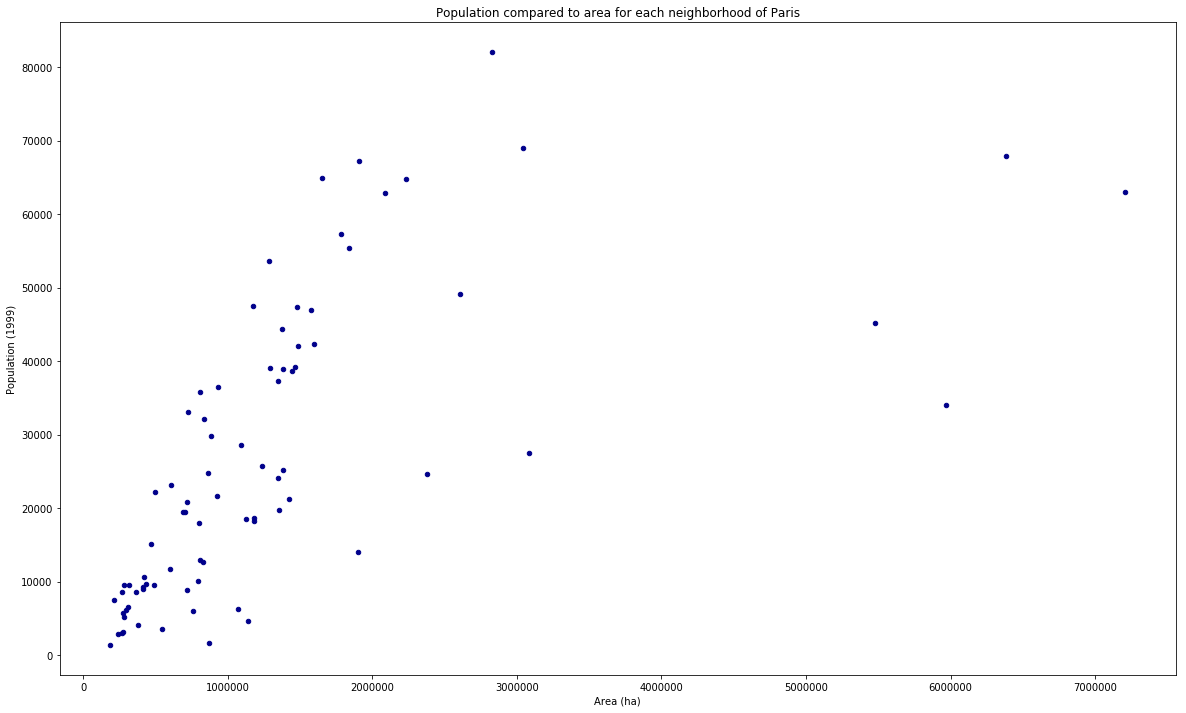

In [24]:
scatter_plot_df.plot(kind='scatter', x='Area', y='Population', figsize=(20, 12), color='darkblue')

plt.title('Population compared to area for each neighborhood of Paris')
plt.xlabel('Area (ha)')
plt.ylabel('Population (1999)')

plt.show()

## Analyse the localisation of seafood restaurants

In [25]:
# The code was removed by Watson Studio for sharing.

In [26]:
CATEGORY = '4bf58dd8d48988d1ce941735' #category for seafood restaurants, see https://developer.foursquare.com/docs/build-with-foursquare/categories/
RADIUS = 500
LIMIT = 100

def get_venues(latitude, longitude, category=CATEGORY, radius=RADIUS, limit=LIMIT):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude,
            category,
            radius, 
            limit)

    results = requests.get(url).json()
    venues_raw = results["response"]['groups'][0]['items']
    
    venues = []
    for venue in venues_raw:
        try:
            venue_id = venue['venue']['id']
            venue_name = venue['venue']['name']
            venue_category = venue['venue']['categories'][0]['name']
            venues.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    
    columns = ['id', 'Name', 'Category']
    
    df = pd.DataFrame(venues,columns=columns)
    return df

In [27]:
seafood_restaurants_paris = pd.DataFrame(columns=['NeighborhoodCode', 'NeighborhoodNumber', 'Neighborhood', 'DistrictNumber', 'Venue_id', 'VenueName'])

for id, neighborhood in paris_neighborhoods.iterrows():
    venues = get_venues(neighborhood['Latitude'], neighborhood['Longitude'])

    for id, venue in venues.iterrows():
        seafood_restaurants_paris = seafood_restaurants_paris.append({'NeighborhoodCode': neighborhood['NeighborhoodCode'], 'NeighborhoodNumber': neighborhood['NeighborhoodNumber'], 'Neighborhood': neighborhood['Neighborhood'], 'DistrictNumber': neighborhood['DistrictNumber'], 'Venue_id': venue['id'], 'VenueName': venue['Name']}, ignore_index=True)

seafood_restaurants_paris.describe()

,NeighborhoodCode,NeighborhoodNumber,Neighborhood,DistrictNumber,Venue_id,VenueName
count,258,258,258,258,258,258
unique,64,64,64,20,179,169
top,7510601,21,Monnaie,6,4d7928ef10936dcbe2335389,La Criée
freq,14,14,14,31,3,7
